<a href="https://colab.research.google.com/github/AlexandreBrown/AerialSemanticSegmentation/blob/main/SemanticSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation

In [1]:
!pip3 install torchvision==0.9.0 torch==1.8.0 matplotlib

# Dependencies

In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
from os import listdir
from os.path import isfile, join
from PIL import Image

In [2]:
torch.manual_seed(42)

# Dataset

In [3]:
class SemanticSegmentationOnDiskDataset(Dataset):
    

  def __init__(self, images_path, masks_path, transform=None):
    self.transform = transform
    self.images_path = images_path
    self.image_file_names = [f for f in listdir(images_path) if isfile(join(images_path, f))]
    self.image_file_names.sort()
    self.masks_path = masks_path
    self.mask_files_names = [f for f in listdir(masks_path) if isfile(join(masks_path, f))]
    self.mask_files_names.sort()
    print("Loaded {0} images loaded from {1}".format(len(self.image_file_names), images_path))
    print("Loaded {0} images loaded from {1}".format(len(self.mask_files_names), masks_path))


  def __len__(self):
    return len(self.image_file_names)


  def __getitem__(self, id):

    img_file_name = self.image_file_names[id]
    img_path = join(self.images_path,img_file_name)
    img = Image.open(img_path)
    
    mask_file_name = self.mask_files_names[id]
    mask_path = join(self.masks_path,mask_file_name)
    mask = Image.open(mask_path)
    
    if self.transform:
        img = self.transform(img)
    
    mask = transforms.Compose([transforms.Resize((388, 388),interpolation=transforms.functional.InterpolationMode.NEAREST)])(mask)
    
    return (img , torch.LongTensor(np.asarray(mask)))

# Define Visualization Utils

In [4]:
def show(image):
    f, ax1 = plt.subplots(1,1)
    
    
    image = image.permute(1, 2, 0).detach().numpy()
    
    ax1.set_title("Image", fontsize=20)
    ax1.figure.set_size_inches(20, 20)
    ax1.imshow(image)
    
    plt.tight_layout()
    plt.show()

# Load & Preprocess data

Loaded 320 images loaded from ./dataset/train/inputs
Loaded 320 images loaded from ./dataset/train/targets
Training dataset


<ipython-input-3-4927b2ed2cdb>:35: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return (img , torch.LongTensor(np.asarray(mask)))


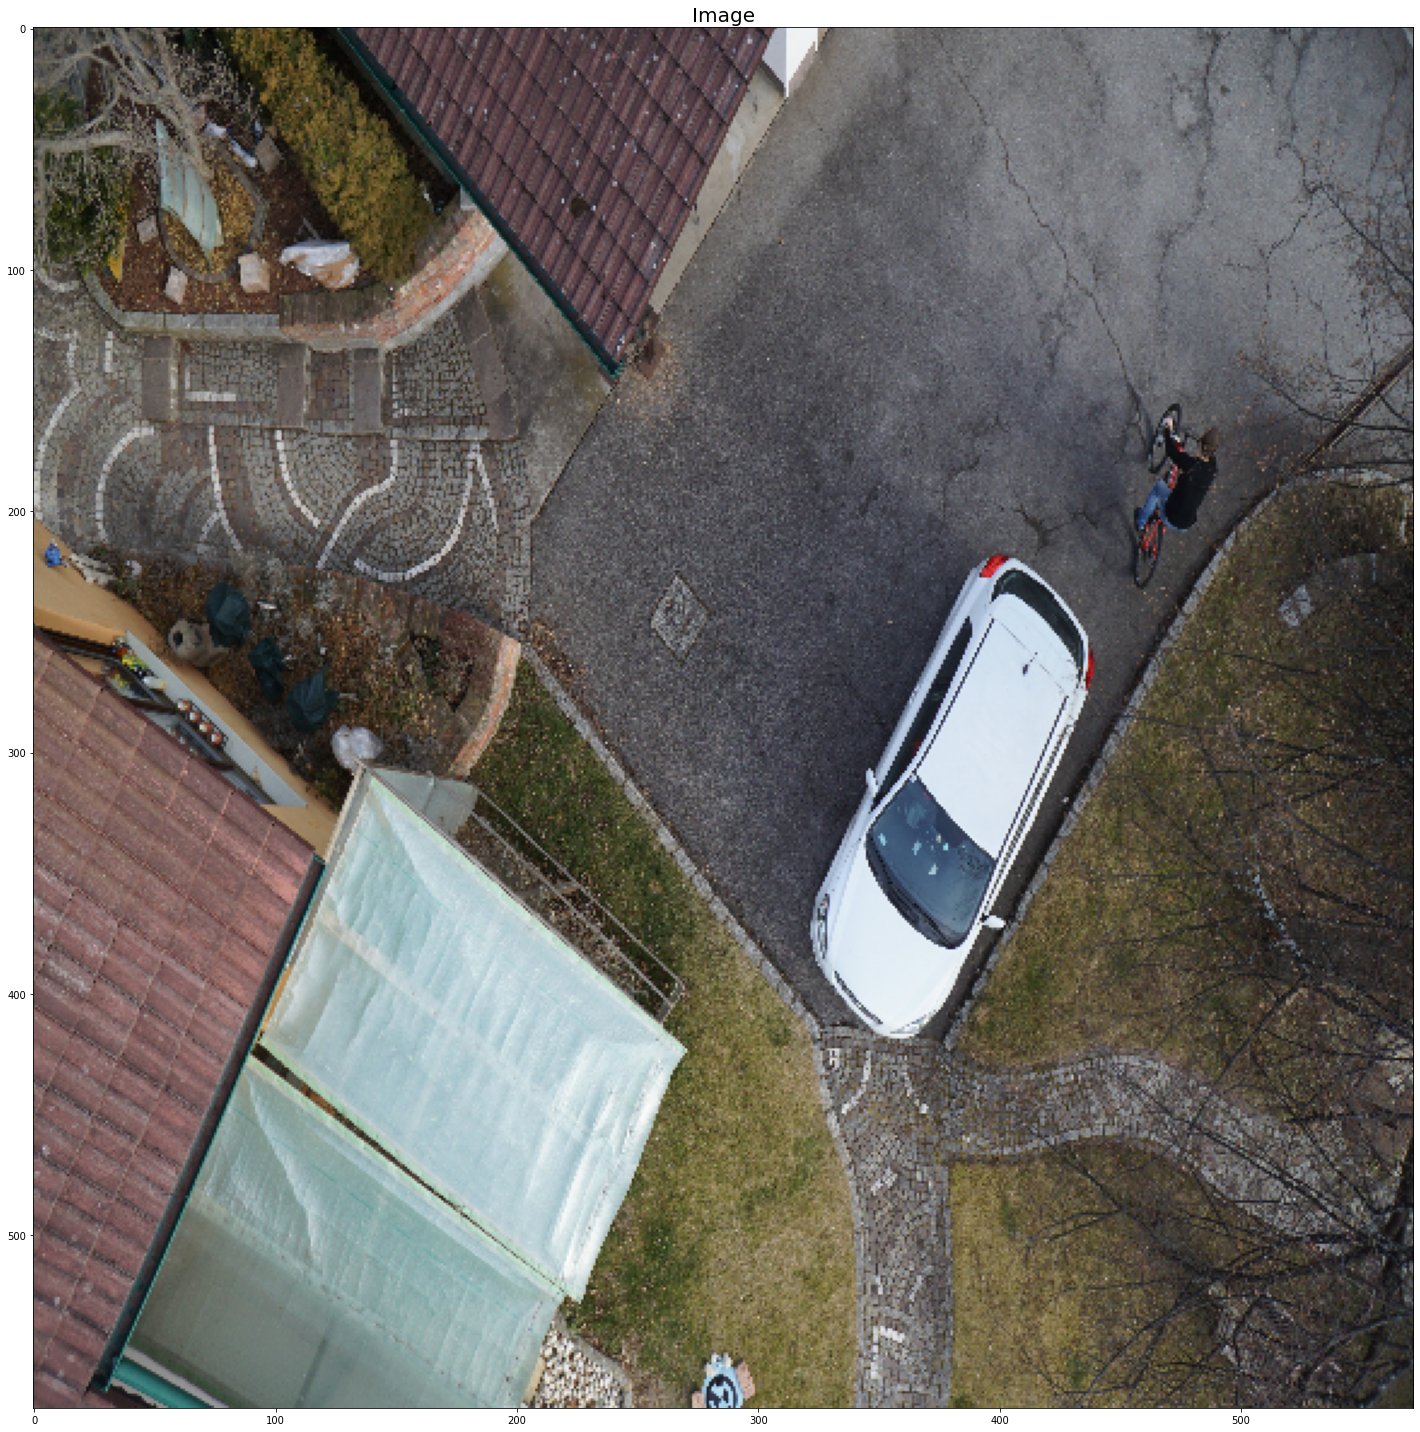

input shape torch.Size([3, 572, 572])
input example : tensor([[[0.3216, 0.2824, 0.3137,  ..., 0.3686, 0.3216, 0.3333],
         [0.2314, 0.2863, 0.3373,  ..., 0.3725, 0.3412, 0.3451],
         [0.2275, 0.2314, 0.3843,  ..., 0.4549, 0.4275, 0.3725],
         ...,
         [0.3608, 0.4039, 0.3804,  ..., 0.2039, 0.1569, 0.1765],
         [0.4039, 0.4078, 0.3765,  ..., 0.1725, 0.1647, 0.1490],
         [0.4392, 0.4471, 0.4118,  ..., 0.2196, 0.2157, 0.1765]],

        [[0.3216, 0.2745, 0.3137,  ..., 0.3843, 0.2980, 0.3412],
         [0.2314, 0.2824, 0.3333,  ..., 0.4588, 0.3373, 0.3608],
         [0.2275, 0.2275, 0.3412,  ..., 0.4941, 0.4431, 0.3961],
         ...,
         [0.2745, 0.2863, 0.2588,  ..., 0.1765, 0.1373, 0.1608],
         [0.2863, 0.3059, 0.2784,  ..., 0.1529, 0.1725, 0.1490],
         [0.3373, 0.3373, 0.3098,  ..., 0.2235, 0.2039, 0.1647]],

        [[0.2902, 0.2863, 0.3137,  ..., 0.3882, 0.3137, 0.3373],
         [0.2235, 0.2627, 0.3176,  ..., 0.4510, 0.3608, 0.3725],
    

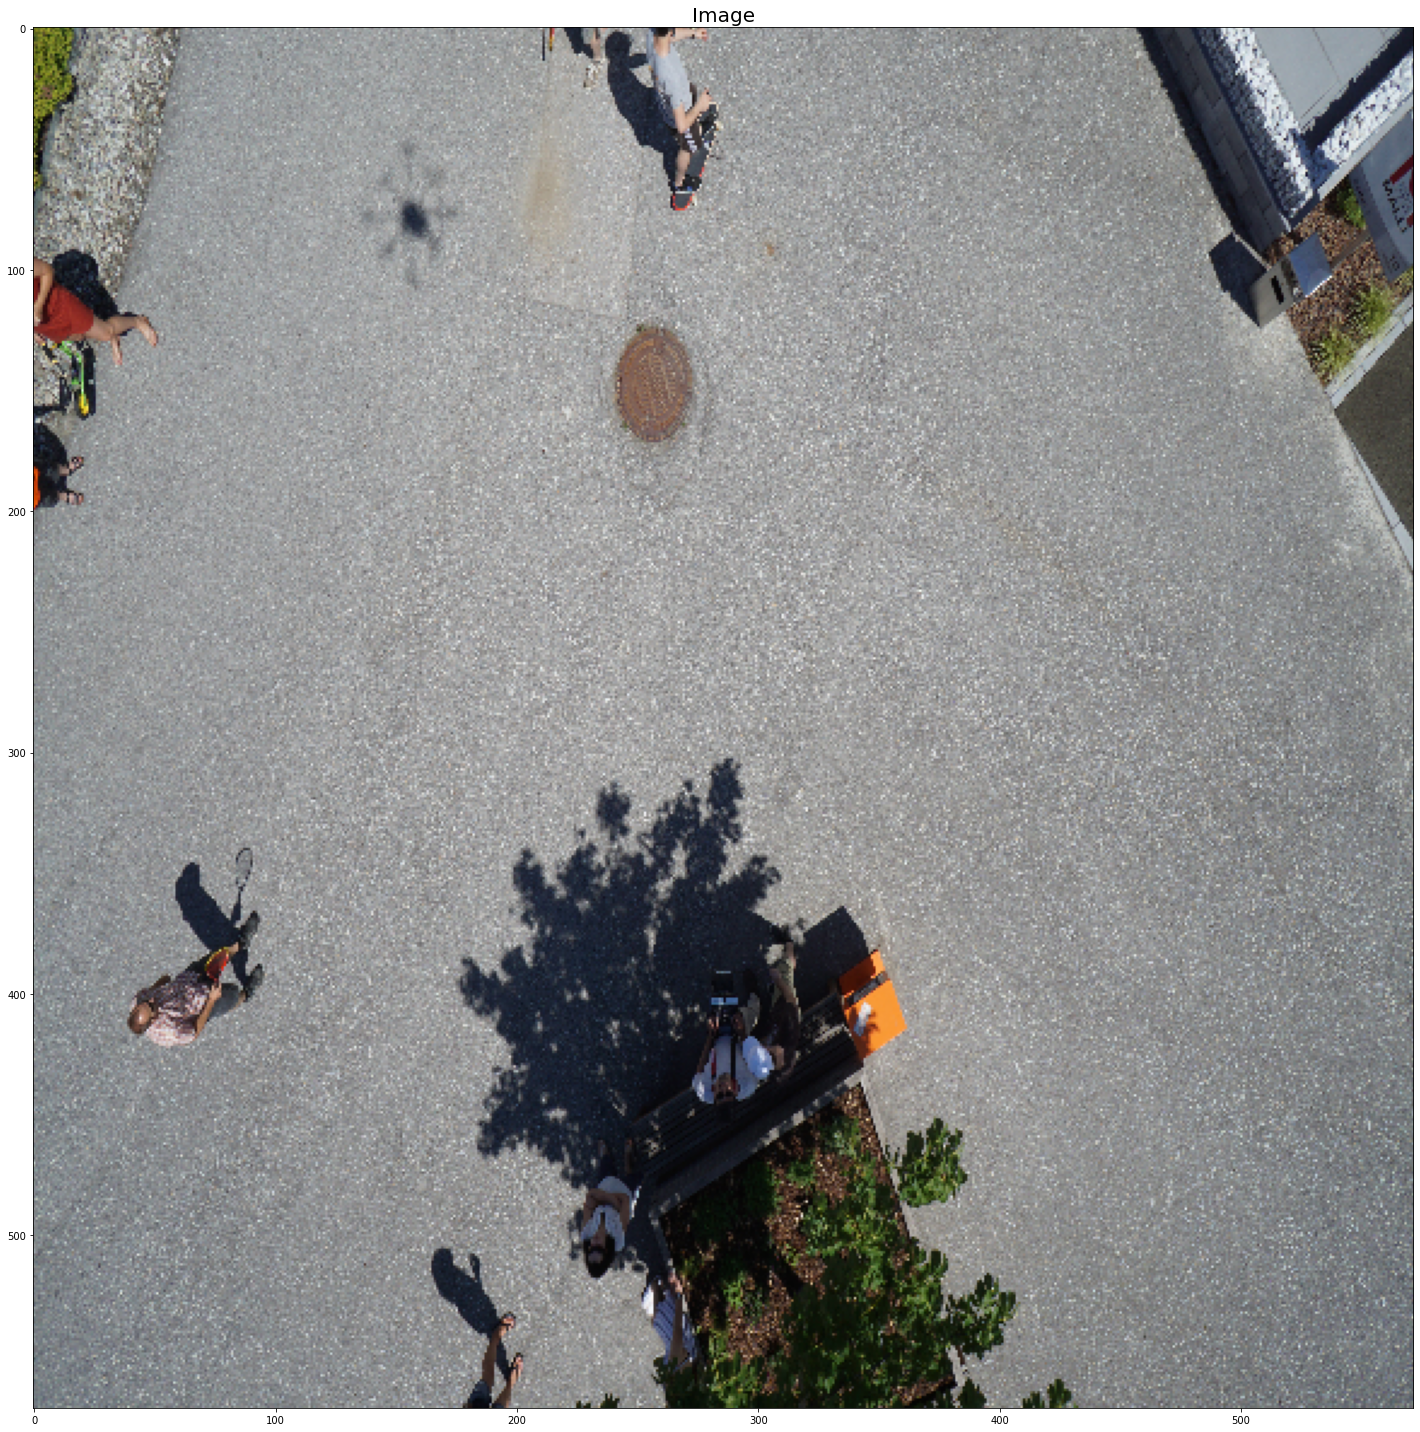

input shape torch.Size([3, 572, 572])
input example : tensor([[[0.4471, 0.4392, 0.3961,  ..., 0.0902, 0.0863, 0.0863],
         [0.3647, 0.5373, 0.4510,  ..., 0.0863, 0.0784, 0.0941],
         [0.3569, 0.3529, 0.3490,  ..., 0.0980, 0.0941, 0.0824],
         ...,
         [0.4353, 0.4275, 0.4824,  ..., 0.3569, 0.4157, 0.4392],
         [0.4549, 0.4588, 0.4980,  ..., 0.5686, 0.4431, 0.4471],
         [0.4275, 0.3843, 0.5373,  ..., 0.5020, 0.3961, 0.4431]],

        [[0.4627, 0.4863, 0.4549,  ..., 0.1137, 0.1176, 0.1098],
         [0.3961, 0.5294, 0.4706,  ..., 0.1216, 0.1098, 0.1098],
         [0.4039, 0.3686, 0.3922,  ..., 0.1059, 0.1059, 0.0902],
         ...,
         [0.4745, 0.4667, 0.5569,  ..., 0.3804, 0.4314, 0.4863],
         [0.4824, 0.4745, 0.5333,  ..., 0.6118, 0.4627, 0.4824],
         [0.4392, 0.4196, 0.5961,  ..., 0.5412, 0.3922, 0.4275]],

        [[0.1608, 0.0941, 0.1294,  ..., 0.1765, 0.1686, 0.1569],
         [0.1020, 0.1333, 0.1412,  ..., 0.1569, 0.1529, 0.1529],
    

In [5]:
HEIGHT = 572
WIDTH = 572

train_path = "./dataset/train/"
train_images_path = train_path + "inputs"
train_masks_path = train_path + "targets"

transform = transforms.Compose([
    transforms.Resize((HEIGHT, WIDTH),interpolation=transforms.functional.InterpolationMode.NEAREST), 
    transforms.ToTensor()
])
train_dataset = SemanticSegmentationOnDiskDataset(train_images_path, train_masks_path, transform)
print("========================================================")
print("Training dataset")
show(train_dataset[0][0])
print("input shape {0}".format(train_dataset[0][0].shape))
print("input example : {0}".format(train_dataset[0][0]))
print("target shape {0}".format(train_dataset[0][1].shape))
print("target example : {0}".format(train_dataset[0][1]))
print("========================================================")

train_path = "./dataset/test/"
test_images_path = train_path + "inputs"
test_masks_path = train_path + "targets"

test_dataset = SemanticSegmentationOnDiskDataset(test_images_path, test_masks_path, transform)
print("========================================================")
print("Testing dataset")
show(test_dataset[0][0])
print("input shape {0}".format(test_dataset[0][0].shape))
print("input example : {0}".format(test_dataset[0][0]))
print("target shape {0}".format(test_dataset[0][1].shape))
print("target example : {0}".format(test_dataset[0][1]))
print("========================================================")

# Model

In [7]:
class UNet(nn.Module):
    
    def __init__(self, number_of_classes):
        super(UNet, self).__init__()
        
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = self.double_conv(3,64)
        self.down_conv_2 = self.double_conv(64,128)
        self.down_conv_3 = self.double_conv(128,256)
        self.down_conv_4 = self.double_conv(256,512)
        self.down_conv_5 = self.double_conv(512,1024)
        
        self.up_transpose_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.up_conv_1 = self.double_conv(1024,512)
        self.up_transpose_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up_conv_2 = self.double_conv(512,256)
        self.up_transpose_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_conv_3 = self.double_conv(256,128)
        self.up_transpose_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up_conv_4 = self.double_conv(128,64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=number_of_classes, kernel_size=1)


    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3),
            nn.ReLU(inplace=True),
        )
        
        
    def forward(self, image):
        
        # Encoder
        x1 = self.down_conv_1(image) #
        x2 = self.max_pool_2x2(x1)
        
        x3 = self.down_conv_2(x2) #
        x4 = self.max_pool_2x2(x3)
        
        x5 = self.down_conv_3(x4) #
        x6 = self.max_pool_2x2(x5)
        
        x7 = self.down_conv_4(x6) #
        x8 = self.max_pool_2x2(x7)
        
        x9 = self.down_conv_5(x8)
        
        # Decoder
        x = self.up_transpose_1(x9)
        y = self.crop_down(x7, x)
        x = torch.cat((x, y), dim=1)
        x = self.up_conv_1(x)
        
        x = self.up_transpose_2(x)
        y = self.crop_down(x5, x)
        x = torch.cat((x, y), dim=1)
        x = self.up_conv_2(x)
        
        x = self.up_transpose_3(x)
        y = self.crop_down(x3, x)
        x = torch.cat((x, y), dim=1)
        x = self.up_conv_3(x)
        
        x = self.up_transpose_4(x)
        y = self.crop_down(x1, x)
        x = torch.cat((x, y), dim=1)
        x = self.up_conv_4(x)
        
        x = self.out(x)
        
        return x
    
    
    def crop_down(self, tensor, target_tensor):
        target_shape = target_tensor.shape[2]
        tensor_shape = tensor.shape[2]
        delta = tensor_shape - target_shape
        delta = delta // 2
        return tensor[:, :, delta:tensor_shape-delta, delta:tensor_shape-delta]

In [8]:
image = torch.randn((1,3,572,572))
model = UNet(number_of_classes=23)

print(model(image))

tensor([[[[-0.0597, -0.0714, -0.0704,  ..., -0.0720, -0.0716, -0.0721],
          [-0.0780, -0.0636, -0.0711,  ..., -0.0643, -0.0611, -0.0641],
          [-0.0680, -0.0754, -0.0746,  ..., -0.0632, -0.0663, -0.0755],
          ...,
          [-0.0807, -0.0648, -0.0740,  ..., -0.0674, -0.0730, -0.0651],
          [-0.0697, -0.0706, -0.0865,  ..., -0.0657, -0.0745, -0.0671],
          [-0.0778, -0.0656, -0.0797,  ..., -0.0709, -0.0736, -0.0657]],

         [[ 0.0293,  0.0423,  0.0325,  ...,  0.0246,  0.0371,  0.0247],
          [ 0.0278,  0.0232,  0.0390,  ...,  0.0311,  0.0326,  0.0304],
          [ 0.0420,  0.0260,  0.0317,  ...,  0.0209,  0.0341,  0.0167],
          ...,
          [ 0.0206,  0.0380,  0.0199,  ...,  0.0310,  0.0280,  0.0341],
          [ 0.0373,  0.0268,  0.0144,  ...,  0.0318,  0.0362,  0.0197],
          [ 0.0300,  0.0267,  0.0298,  ...,  0.0251,  0.0259,  0.0250]],

         [[ 0.0844,  0.0822,  0.0856,  ...,  0.0949,  0.0933,  0.0832],
          [ 0.1012,  0.0828,  

# Training

In [13]:
train_batch = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch)

test_batch = 10
test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch)

number_of_classes=23
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(number_of_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr=0.003)

n_epochs=3
cost_list=[]
accuracy_list=[]
COST=0

def train_model(n_epochs, model):
    for epoch in range(n_epochs):
        COST=0
        model.train()
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST+=loss.data
            
        print("COST {0}".format(COST))

        cost_list.append(COST)
        correct=0
        model.eval()
        for x_test, y_test in test_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            accuracy = correct / (y_test.shape[1] * y_test[2])
            accuracy_list.append(accuracy)
        
train_model(n_epochs, model)
plt.plot(accuracy_list)
plt.show()

RuntimeError: CUDA out of memory. Tried to allocate 318.00 MiB (GPU 0; 10.91 GiB total capacity; 8.87 GiB already allocated; 154.00 MiB free; 9.15 GiB reserved in total by PyTorch)